# Module 2: Unsupervised Learning
[Computational Genomics Chapter 4](http://compgenomr.github.io/book/unsupervisedLearning.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import rdata

### 2.1 Clustering: Grouping samples based on their similarity

##### 2.1.1 Distance metrics 

* Manhatten distance (L1 norm): $d_{AB} = \sum^n_{i=1}|e_{A_i}-e_{B_i}|$
* Euclidian distance (L2 norm): $d_{AB} = \sqrt{\sum^n_{i=1}(e_{A_i}-e_{B_i})^2}$. Due to the $^2$ operation, it can be more affected by outliers than the Manhatten distance. Still, is the default for clustering.
* Correlation distance: $d_{AB} = 1 - \rho$, where $\rho$ is the Pearson correlation coefficient between two vectors. Depicts the linear correlation between two expression patterns well.

In [13]:
df = pd.DataFrame({'IRX4': [11, 13, 2, 1],
                   'OCT4': [10, 13, 4, 3],
                   'PAX6': [1, 3, 10, 9]})
print('Expression data:')
print(df)

# Manhattan distance
manhattan = squareform(pdist(df, metric='cityblock'))
print('Manhattan distances:')
print(manhattan)

# Euclidian distance
euclidean = squareform(pdist(df, metric='euclidean'))
print('Euclidian distances:')
print(euclidean)

# Correlation distance
correlation_distance = 1 - np.corrcoef(df.T)
print('Correlation distances:')
print(correlation_distance)

Expression data:
   IRX4  OCT4  PAX6
0    11    10     1
1    13    13     3
2     2     4    10
3     1     3     9
Manhattan distances:
[[ 0.  7. 24. 25.]
 [ 7.  0. 27. 28.]
 [24. 27.  0.  3.]
 [25. 28.  3.  0.]]
Euclidian distances:
[[ 0.          4.12310563 14.07124728 14.59451952]
 [ 4.12310563  0.         15.84297952 16.73320053]
 [14.07124728 15.84297952  0.          1.73205081]
 [14.59451952 16.73320053  1.73205081  0.        ]]
Correlation distances:
[[0.00000000e+00 7.96902573e-03 1.93686634e+00]
 [7.96902573e-03 0.00000000e+00 1.88740111e+00]
 [1.93686634e+00 1.88740111e+00 2.22044605e-16]]


* Scaling before clustering: normalization of data leads to more comparable values.

##### 2.1.2 Hierarchical clustering

Linkage types:
* Complete: The distance between two clusters is defined as the largest distance between any members of the two clusters.
* Single: The distance between two clusters is defined as the smallest distance between any members of the two clusters.
* Average / UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method: The distance between two clusters is defined as the average distance between any members of the two clusters.
* Ward.D2, ward.D: Different implementations of Ward’s minimum variance method. This method aims to find compact, spherical clusters by selecting clusters to merge based on the change in the cluster variances. The clusters are merged if the increase in the combined variance over the sum of the cluster-specific variances is the minimum compared to alternative merging operations.

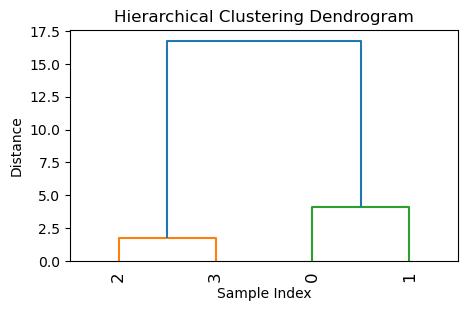

In [16]:
# Euclidean distance matrix 
distance_matrix = pdist(df, metric='euclidean')

# Perform hierarchical clustering using the "complete" linkage method
hc = linkage(distance_matrix, method='complete')

# Plot dendogram
plt.figure(figsize=(5, 3))
dendrogram(hc, labels=df.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [2]:
# Load the leukemia expression subset dataset 
r_data = rdata.parser.parse_file("/Users/olyssa/Downloads/compGenomRData-1-2.0/inst/extdata/leukemiaExpressionSubset.rds")
as_dict = rdata.conversion.convert(r_data)
exp_file = pd.DataFrame(as_dict)
exp_file = exp_file.set_axis(list(as_dict.dim_1.to_numpy()), axis=1)
exp_file = exp_file.set_axis(list(as_dict.dim_0.to_numpy()), axis=0)

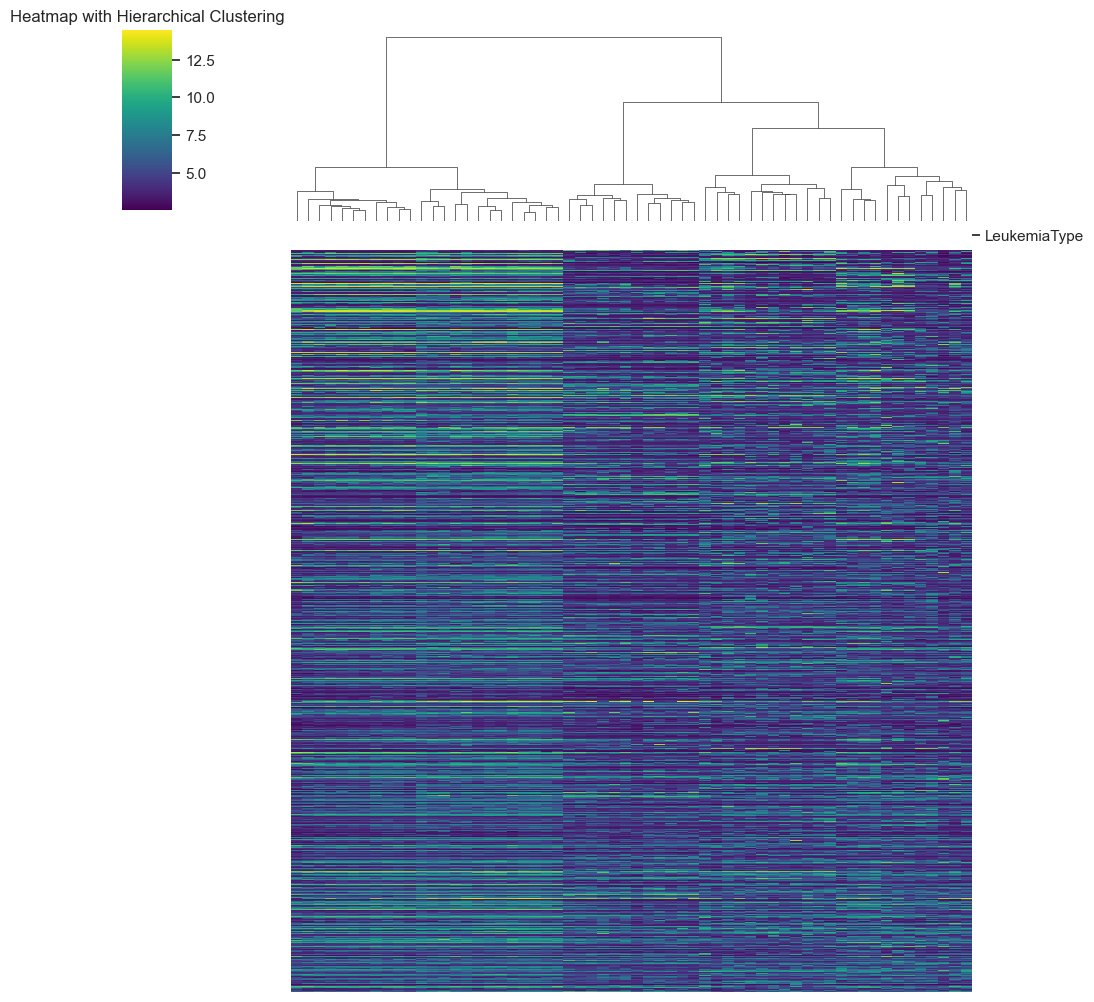

In [3]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# Create sample annotations
mat = exp_file
annotation_col = pd.DataFrame({
    'LeukemiaType': [col[:3] for col in mat.columns]
}, index=mat.columns)

# Perform hierarchical clustering on columns
col_dist = pdist(exp_file.T, metric='euclidean')  # Transpose for column clustering
col_linkage = linkage(col_dist, method='ward')  # Ward.D2 is equivalent to Ward in scipy

# Plot heatmap using seaborn
sns.set_theme(style="white")

# Create the heatmap
g = sns.clustermap(
    exp_file, 
    row_cluster=False,  # No clustering for rows 
    col_cluster=True,   # Column clustering
    col_linkage=col_linkage,
    row_colors=None,    
    col_colors=annotation_col["LeukemiaType"].map({
        "abc": "red",   # Map leukemia types to colors 
        "def": "blue",
        "ghi": "green"
    }),
    cmap="viridis", 
    xticklabels=False, 
    yticklabels=False
)

# Add a title to the plot
plt.title("Heatmap with Hierarchical Clustering")
plt.show()

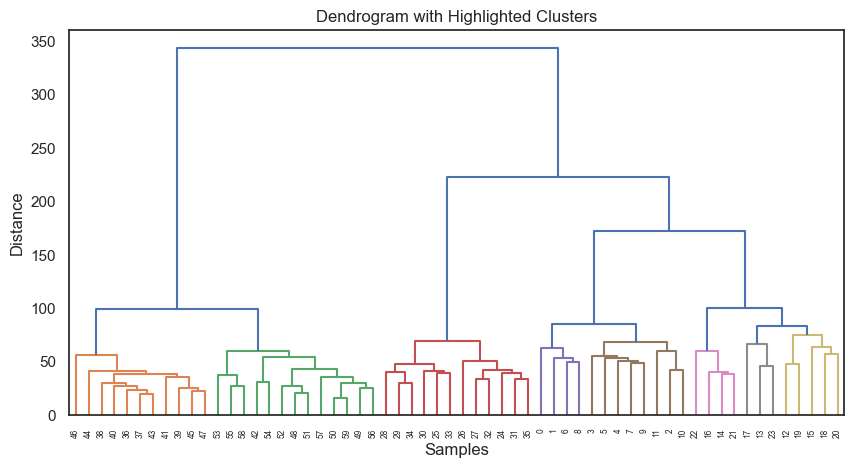

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

mat = exp_file

# Compute distance matrix and hierarchical clustering on transposed matrix
dist_matrix = pdist(mat.T, metric='euclidean')  # Distance on transposed matrix
hcl = linkage(dist_matrix, method='ward') 

plt.figure(figsize=(10, 5))
dendro = dendrogram(
    hcl,
    labels=None,  
    color_threshold=80  # Highlight clusters at height 80
)

# Manually adjust leaf node height
# This is a substitute for R's `hang=-1`, pulling leaf nodes to the baseline
ax = plt.gca()
for line in ax.collections[1].get_segments():
    line[0][1] = 0  # Set leaf's starting y-coordinate to 0
    line[1][1] = 0

# Highlight clusters with a rectangle
h = 80
clusters = fcluster(hcl, h, criterion='distance')  # Identify clusters at height h

plt.title("Dendrogram with Highlighted Clusters")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [84]:
mat = exp_file

# Perform hierarchical clustering
dist_matrix = pdist(mat.T, metric='euclidean')  # Distance on transposed matrix
hcl = linkage(dist_matrix, method='ward')  # Equivalent to hclust(dist(t(mat)))

# Cut tree to form 5 clusters (similar to cutree with k=5)
clu_k5 = fcluster(hcl, t=5, criterion='maxclust')

# Cut tree at height 80 (similar to cutree with h=80)
clu_h80 = fcluster(hcl, t=80, criterion='distance')

# Display the number of samples for each cluster for clu_k5
print("Cluster sizes with k=5:")
print(pd.Series(clu_k5).value_counts())

# Display the number of samples for each cluster for clu_h80
print("\nCluster sizes with h=80:")
print(pd.Series(clu_h80).value_counts())

Cluster sizes with k=5:
1    24
3    12
2    12
5     8
4     4
Name: count, dtype: int64

Cluster sizes with h=80:
2    13
3    12
1    11
5     8
8     5
4     4
6     4
7     3
Name: count, dtype: int64


##### 2.1.3 K-means clustering

In [6]:
from sklearn.cluster import KMeans

mat = exp_file

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=101, n_init=10)
kmeans.fit(mat.T)

# Cluster assignments
clusters = kmeans.labels_

# Number of data points in each cluster
cluster_counts = pd.Series(clusters).value_counts()

# Display the cluster sizes
print("Number of data points in each cluster:")
print(cluster_counts)

Number of data points in each cluster:
4    15
1    12
2    12
0    11
3    10
Name: count, dtype: int64


In [7]:
mat = exp_file

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=101, n_init=10)
kmeans.fit(mat.T)

# Cluster assignments
clusters = kmeans.labels_

# Create the LeukemiaType annotations based on column names
leukemia_type = [str(col)[:3] for col in mat.columns]

# Create a DataFrame combining LeukemiaType and cluster assignments
type2kclu = pd.DataFrame({
    'LeukemiaType': leukemia_type,
    'cluster': clusters
})

# Count occurrences of each LeukemiaType-cluster combination
cluster_counts = type2kclu.groupby(['LeukemiaType', 'cluster']).size()

# Display the results
print("Cluster counts based on LeukemiaType and cluster:")
print(cluster_counts)

Cluster counts based on LeukemiaType and cluster:
LeukemiaType  cluster
ALL           1          12
AML           3          10
              4           2
CLL           2          12
CML           0          11
              4           1
NoL           4          12
dtype: int64


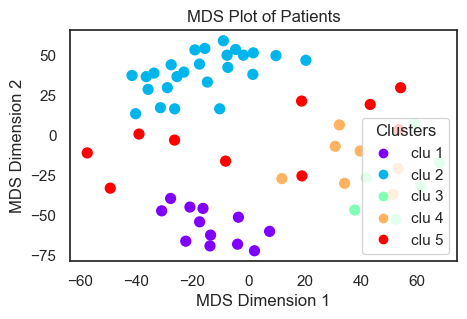

In [32]:
# Visualization of clusters

from sklearn.cluster import KMeans
from sklearn.manifold import MDS # Multi-dimensional scaling

mat = exp_file

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=101, n_init='auto')
kmeans.fit(mat.T)

# Cluster assignments
clusters = kmeans.labels_

# Calculate pairwise distances between the patients (columns)
dists = pdist(mat.T, metric='euclidean') 

# Perform MDS (multidimensional scaling)
mds = MDS(n_components=2, dissimilarity='precomputed', 
          random_state=101,
          normalized_stress='auto')
mds_coords = mds.fit_transform(squareform(dists))

# Plot the patients in the 2D MDS space, color by cluster
plt.figure(figsize=(5, 3))
scatter = plt.scatter(mds_coords[:, 0], mds_coords[:, 1], c=clusters, cmap='rainbow', s=50)

# Add legend for cluster colors
plt.legend(handles=scatter.legend_elements()[0], labels=[f'clu {i+1}' for i in range(5)],
           title="Clusters", loc='lower right')

plt.title("MDS Plot of Patients")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

##### 2.1.4 How to choose "k", the number of clusters 

###### 2.1.4.1 Silhouette
Measure the expected self-similar nature of the points in a set of clusters:
$$s(i) = \frac{b(i)-a(i)}{max{a(i), b(i)}}$$

Silhouette Score: 0.3031796443847737


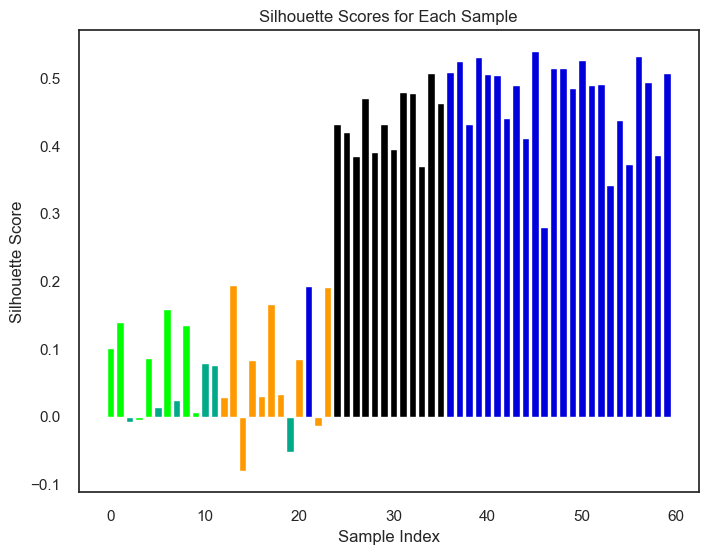

In [87]:
from sklearn.metrics import silhouette_score

mat_t = exp_file.T

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=101, n_init='auto')
kmeans.fit(mat_t)

# Cluster assignments
clusters = kmeans.labels_

# Calculate the Silhouette Score for all data points
silhouette_avg = silhouette_score(mat_t, clusters, metric='euclidean')
print(f"Silhouette Score: {silhouette_avg}")

# Visualizing silhouette scores for each sample
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(mat_t, clusters)

# Plot the silhouette scores for each sample
plt.figure(figsize=(8, 6))
plt.bar(range(len(sample_silhouette_values)), sample_silhouette_values, color=plt.cm.nipy_spectral(clusters / 5.))
plt.xlabel('Sample Index')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Each Sample')
plt.show()

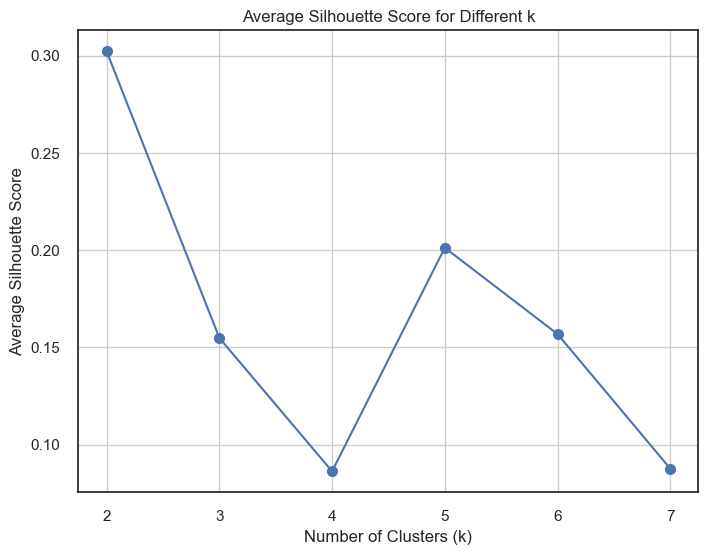

In [88]:
from sklearn_extra.cluster import KMedoids

mat_t = exp_file.T

# Function to calculate the average silhouette score for different k values (from 2 to 7)
Ks = []
for i in range(2, 8):  # k values from 2 to 7
    kmedoids = KMedoids(n_clusters=i, random_state=101, metric='euclidean')
    kmedoids.fit(mat_t)  # Fit the model to the transposed matrix
    cluster_labels = kmedoids.labels_
    
    # Calculate the silhouette score (average silhouette width)
    silhouette_avg = silhouette_score(mat_t, cluster_labels, metric='euclidean')
    Ks.append(silhouette_avg)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(range(2, 8), Ks, marker='o', linestyle='-', color='b', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score for Different k')
plt.grid(True)
plt.show()

###### 2.1.4.2 Gap statistic
* Within-cluster variation: $W_k = \sum^K_{k=1}\sum_{\bf{x}_i \in C_k} (\bf{x}_i-\mu_k)^2$
* Gap statistic: $Gap_n(k) = E_n^* {log W_k}-log W_k$, where $E_n^* {log W_k}$ is the expected variation in log-scale under a sample size $n$ from the reference distribution and $log W_k$ is the observed variation. The aim is then to choose the number $k$ in order to maximize $Gap_n(k)$.

/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To re

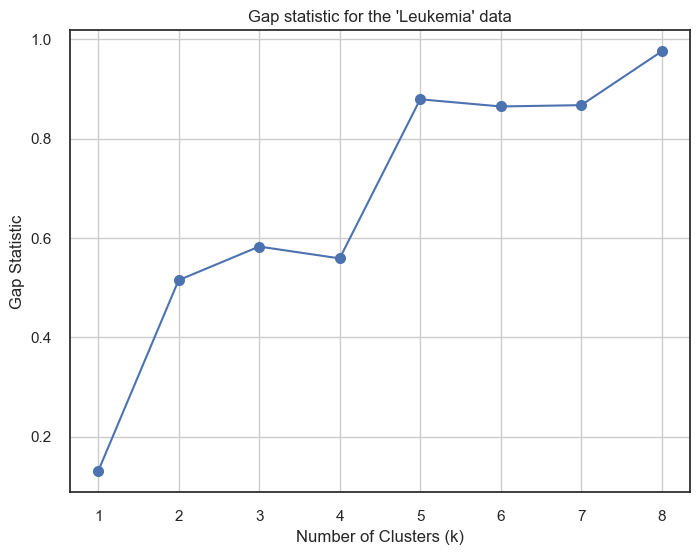

In [89]:
from sklearn.metrics import pairwise_distances

mat = exp_file

# Function to compute the within-cluster sum of squares (W_k)
def compute_wk(data, labels):
    cluster_centers = np.array([data[labels == i].mean(axis=0) for i in np.unique(labels)])
    dist_matrix = np.array([np.sum((data[labels == i] - cluster_centers[i]) ** 2) for i in range(len(cluster_centers))])
    return np.sum(dist_matrix)

# Gap statistic function
def gap_statistic(data, k_max, B=50):
    gap_values = []
    for k in range(1, k_max+1):
        # Fit the KMedoids clustering
        kmedoids = KMedoids(n_clusters=k, random_state=101, metric='euclidean')
        kmedoids.fit(data)
        # Compute the W_k for the actual data
        Wk = compute_wk(data, kmedoids.labels_)
        
        # Create random reference datasets and compute W_k for each reference
        Wk_ref = []
        for b in range(B):
            random_data = np.random.uniform(data.min(), data.max(), size=data.shape)  # Random uniform reference data
            kmedoids_ref = KMedoids(n_clusters=k, random_state=101, metric='euclidean')
            kmedoids_ref.fit(random_data)
            Wk_ref.append(compute_wk(random_data, kmedoids_ref.labels_))
        
        # Compute the gap statistic
        gap_value = np.log(np.mean(Wk_ref)) - np.log(Wk)
        gap_values.append(gap_value)
    
    return gap_values

# Calculate the Gap Statistic for k = 1 to k = 8
gap_values = gap_statistic(mat.T, k_max=8, B=50)

# Plot the Gap Statistic
plt.figure(figsize=(8, 6))
plt.plot(range(1, 9), gap_values, marker='o', linestyle='-', color='b', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title("Gap statistic for the 'Leukemia' data")
plt.grid(True)
plt.show()

/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packa

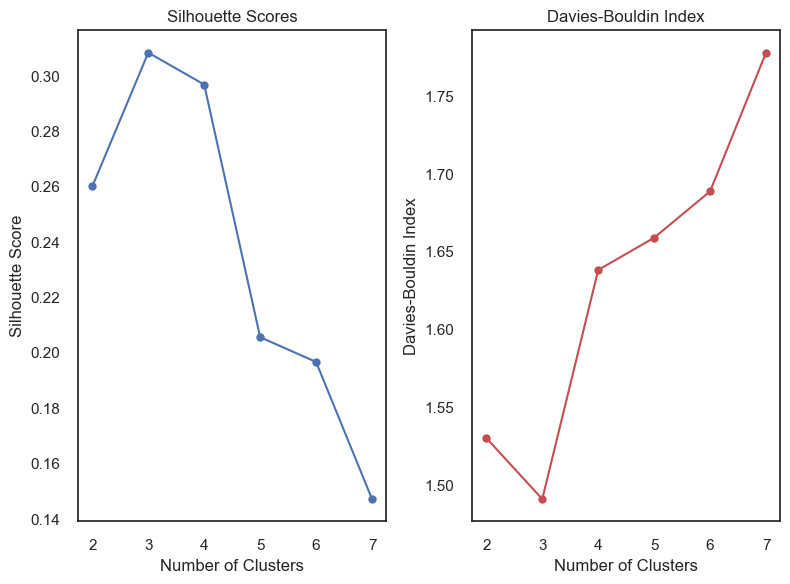

Best k based on Silhouette Score: 3
Best k based on Davies-Bouldin Index: 3


In [90]:
# other methods

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

data = exp_file.T

# Standardize the data 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Define the range of cluster numbers to test
k_range = range(2, 8)

# Store the scores for each k
silhouette_scores = []
db_scores = []
gap_scores = []

# Calculate the clustering scores for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(data_scaled)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(data_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(data_scaled, kmeans.labels_)
    db_scores.append(db_index)

    # Gap Statistic

# Plot the results of the metrics to find the best k
plt.figure(figsize=(12, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, marker='o', color='b', label="Silhouette Score")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

# Davies-Bouldin Index
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o', color='r', label="Davies-Bouldin Index")
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

## Gap Statistic
# plt.subplot(1, 3, 3)
# plt.plot(k_range, gap_scores, marker='o', color='g', label="Gap Statistic")
# plt.xlabel('Number of Clusters')
# plt.ylabel('Gap Statistic')
# plt.title('Gap Statistic')

plt.tight_layout()
plt.show()

# Based on the scores, you can choose the best number of clusters
# For example, picking the value with the highest silhouette score
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f"Best k based on Silhouette Score: {best_k_silhouette}")
print(f"Best k based on Davies-Bouldin Index: {best_k_db}")


### 2.2 Dimensionality reduction techniques

##### 2.2.1 Principal component analysis (PCA)
PCA rotates the original data space such that the axes of the new coordinate system point to the directions of highest variance of the data. The axes or new variables are termed principal components (PCs) and are ordered by variance: The first component, PC 1, represents the direction of the highest variance of the data. The direction of the second component, PC 2, represents the highest of the remaining variance orthogonal to the first component.

Covariance of pairwise variables: $cov(X, Y) = \frac{1}{n}\sum^n_{i=1}(x_i-\mu_X)(y_i-\mu_Y)$, where $X$ and $Y$ are the expression values of genes in a sample in our example.

Eigenvectors and eigenvalues of the covariance matrix indicate the direction and the magnitude of variation of the data. In our visual example, the eigenvectors are so-called principal components. The eigenvector indicates the direction and the eigenvalues indicate the variation in that direction.

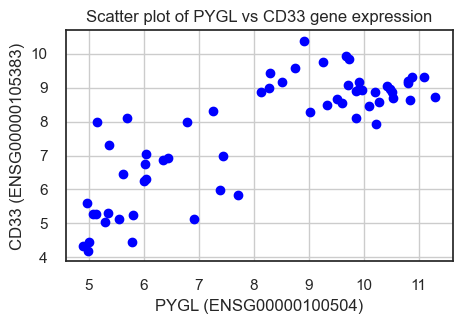

In [94]:
mat = exp_file

# Extract the rows corresponding to the gene IDs of interest
gene_1 = mat.loc["ENSG00000100504", :]  # PYGL (ENSG00000100504)
gene_2 = mat.loc["ENSG00000105383", :]  # CD33 (ENSG00000105383)

# Plot the data
plt.figure(figsize=(5, 3))
plt.scatter(gene_1, gene_2, c='blue', marker='o')  # Scatter plot with solid circles (pch=19 equivalent)
plt.xlabel("PYGL (ENSG00000100504)")  # X-axis label
plt.ylabel("CD33 (ENSG00000105383)")  # Y-axis label
plt.title("Scatter plot of PYGL vs CD33 gene expression")  # Title of the plot
plt.grid(True)  # Add grid for better readability
plt.show()

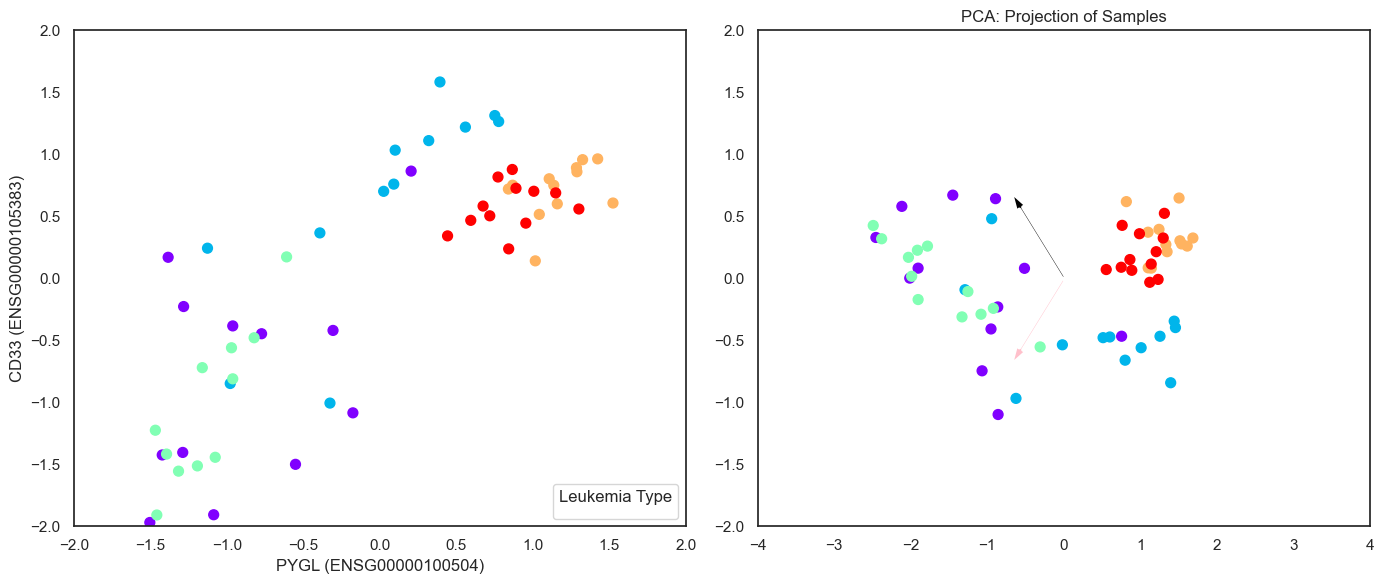

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mat = exp_file

# Annotation
annotation_col = pd.DataFrame({
    'LeukemiaType': [col[:3] for col in mat.columns]
}, index=mat.columns)

# Set up the plot area to have two subplots side by side (equivalent to par(mfrow=c(1,2)))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subset the data with two specific genes (transposing so samples are on the columns)
sub_mat = mat.loc[["ENSG00000100504", "ENSG00000105383"], :].T

# Plotting the scatter plot of the two genes of interest
# Scaling the data (standardizing) before plotting
gene_1_scaled = StandardScaler().fit_transform(mat.loc["ENSG00000100504", :].values.reshape(-1, 1))
gene_2_scaled = StandardScaler().fit_transform(mat.loc["ENSG00000105383", :].values.reshape(-1, 1))

axes[0].scatter(gene_1_scaled, gene_2_scaled, c=pd.factorize(annotation_col['LeukemiaType'])[0], cmap='rainbow', s=50)
axes[0].set_xlabel("PYGL (ENSG00000100504)")
axes[0].set_ylabel("CD33 (ENSG00000105383)")
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)

# Adding legend
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, np.unique(annotation_col['LeukemiaType']), title="Leukemia Type", loc="lower right")

# Perform PCA for the subset of genes
pca = PCA(n_components=2)
sub_mat_scaled = StandardScaler().fit_transform(sub_mat)  # Standardize the data for PCA
pr = pca.fit(sub_mat_scaled)

# Plot the direction of eigenvectors
axes[1].quiver(0, 0, pr.components_[0, 0], pr.components_[0, 1], angles='xy', scale_units='xy', scale=1, color='pink', linewidth=3)
axes[1].quiver(0, 0, pr.components_[1, 0], pr.components_[1, 1], angles='xy', scale_units='xy', scale=1, color='black', linewidth=3)

# Plot the samples in the new coordinate system (PCA scores)
axes[1].scatter(-pr.transform(sub_mat_scaled)[:, 0], -pr.transform(sub_mat_scaled)[:, 1], 
                c=pd.factorize(annotation_col['LeukemiaType'])[0], cmap='rainbow', s=50)

axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-2, 2)
axes[1].set_title("PCA: Projection of Samples")
plt.tight_layout()
plt.show()

###### Singular value decomposition (SVD) and principal component analysis:
A more common way to calculate PCA is through something called singular value decomposition (SVD). This results in another interpretation of PCA, which is called “latent factor” or “latent component” interpretation. In a moment, it will be clearer what we mean by “latent factors”. SVD is a matrix factorization or decomposition algorithm that decomposes an input matrix $X$ as follows:
$$X = U S V^T$$
Here, $X$ resembles the samples, $U$ the Eigenarrays / Eigenassays, $S$ the singular values, and $V^T$ the Eigenvectors / Eigengenes.

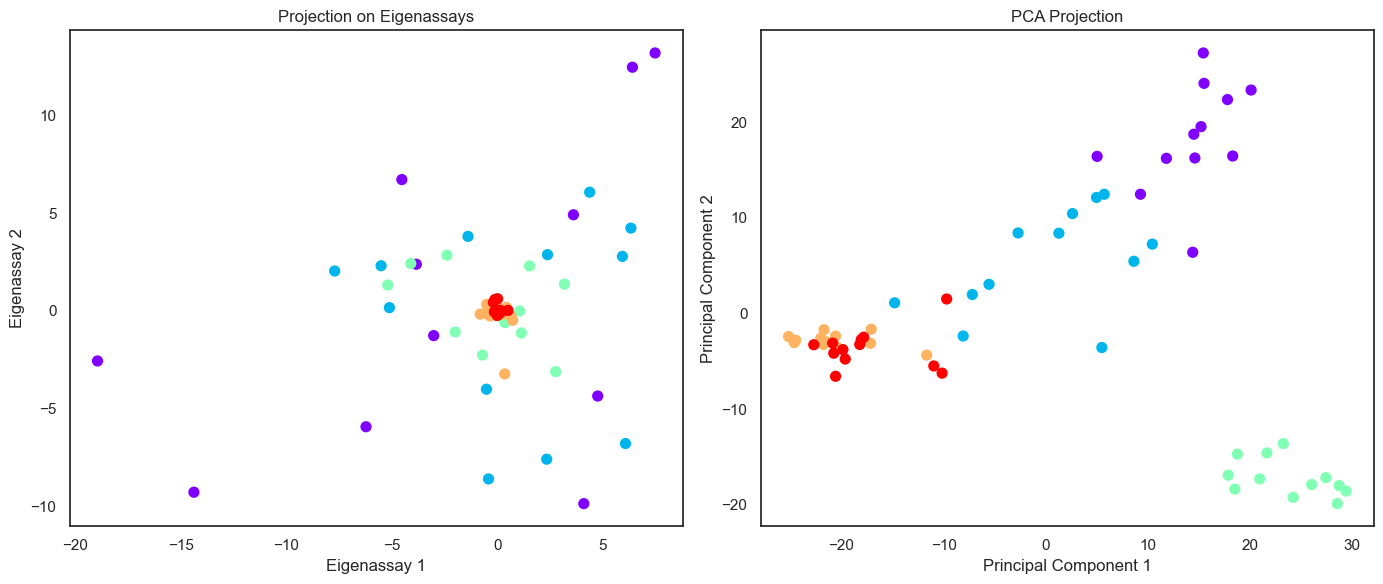

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mat = exp_file

# Annotation
annotation_col = pd.DataFrame({
    'LeukemiaType': [col[:3] for col in mat.columns]
}, index=mat.columns)

# Set up the plot area to have two subplots side by side (equivalent to par(mfrow=c(1,2)))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Apply SVD to the scaled matrix
scaler = StandardScaler()
scaled_mat = scaler.fit_transform(mat.T)  # Transpose before scaling to make samples along columns

U, S, Vt = np.linalg.svd(scaled_mat, full_matrices=False)  # SVD on the scaled matrix

# Projection on eigenassays (U matrix multiplied by S)
assays = np.dot(U, np.diag(S))

# Plot the first two eigenassays as a scatter plot
axes[0].scatter(assays[0, :], assays[1, :], c=pd.factorize(annotation_col['LeukemiaType'])[0], cmap='rainbow', s=50)
axes[0].set_xlabel('Eigenassay 1')
axes[0].set_ylabel('Eigenassay 2')
axes[0].set_title('Projection on Eigenassays')

# Perform PCA on the transposed matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_mat)  # Apply PCA on the transposed matrix

# Plot the PCA result
axes[1].scatter(pca_result[:, 0], pca_result[:, 1], c=pd.factorize(annotation_col['LeukemiaType'])[0], cmap='rainbow', s=50)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('PCA Projection')

# Show the plot
plt.tight_layout()
plt.show()

##### 2.2.2 Other matrix factorization methods for dimensionality reduction

##### 2.2.3 Multi-dimensional scaling (MDS)
MDS is a set of data analysis techniques that displays the structure of distance data in a high-dimensional space into a lower dimensional space without much loss of information. The overall goal of MDS is to faithfully represent the distances with the lowest possible dimensions.
Algorithm:
1. Find a random low-dimensional configuration of points, or in the variant we will be using below we start with the configuration returned by classical MDS.
2. Calculate the distances between the points in the low dimension $||z_i-z_j||$, $z_i$ and $z_j$ are vectors of positions for samples. 
3. Find the optimal monotonic transformation of the input distance, $\theta(d_{ij})$, to approximate input distances to low-dimensional distances. This is achieved by isotonic regression, where a monotonically increasing free-form function is fit. This step practically ensures that ranking of low-dimensional distances are similar to rankings of input distances.
4. Minimize the stress function by re-configuring low-dimensional space and keeping function constant.
5. Repeat steps 2 to 4 until convergence.

/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


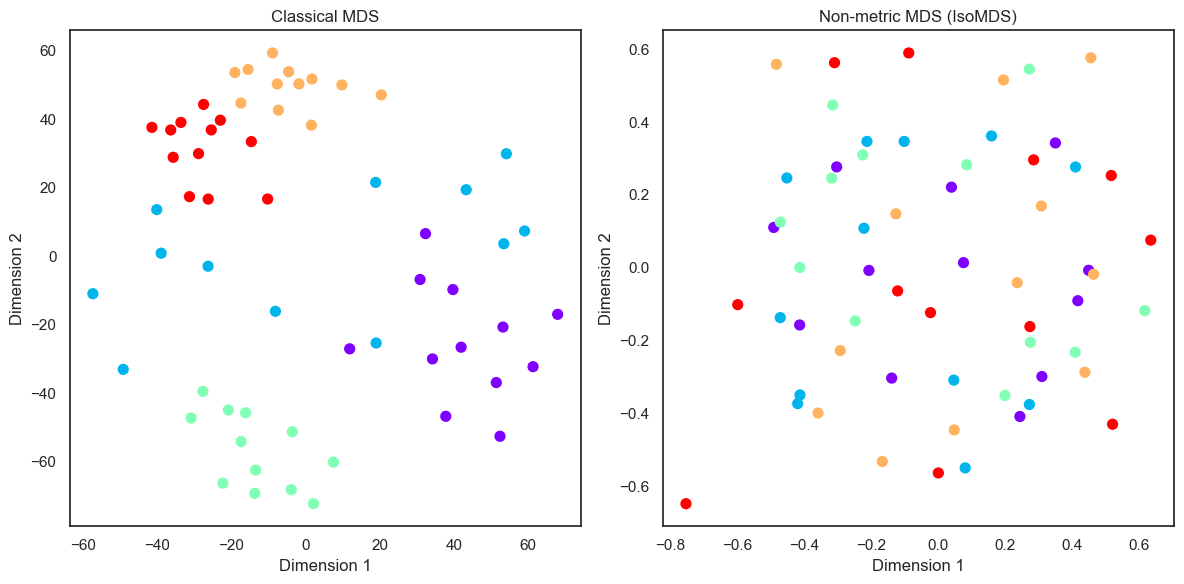

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

mat = exp_file

# Annotation
annotation_col = pd.DataFrame({
    'LeukemiaType': [col[:3] for col in mat.columns]
}, index=mat.columns)

# Transpose the matrix (samples on rows)
mat_t = mat.T

# Classical MDS (cmdscale in R)
mds = MDS(n_components=2, metric=True, random_state=101)  # Classical MDS (cmdscale equivalent)
mds_result = mds.fit_transform(mat_t)

# Non-metric MDS (isoMDS in R)
mds_non_metric = MDS(n_components=2, metric=False, random_state=101)  # Non-metric MDS (isoMDS equivalent)
mds_non_metric_result = mds_non_metric.fit_transform(mat_t)

# Plot the results side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Classical MDS
axes[0].scatter(mds_result[:, 0], mds_result[:, 1], c=pd.factorize(annotation_col['LeukemiaType'])[0], cmap='rainbow', s=50)
axes[0].set_title('Classical MDS')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

# Plot for Non-metric MDS
axes[1].scatter(mds_non_metric_result[:, 0], mds_non_metric_result[:, 1], c=pd.factorize(annotation_col['LeukemiaType'])[0], cmap='rainbow', s=50)
axes[1].set_title('Non-metric MDS (IsoMDS)')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

##### 2.2.4 t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE maps the distances in high-dimensional space to lower dimensions and it is similar to the MDS method in this respect. But the benefit of this particular method is that it tries to preserve the local structure of the data ("perplexity") so the distances and grouping of the points we observe in lower dimensions such as a 2D scatter plot is as close as possible to the distances we observe in the high-dimensional space.

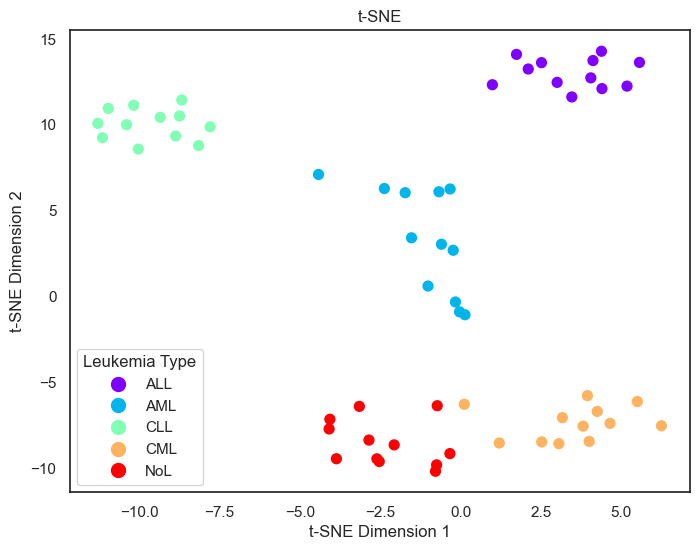

In [37]:
from sklearn.manifold import TSNE

mat = exp_file 
annotation_col = pd.DataFrame({
    'LeukemiaType': [col[:3] for col in mat.columns]
}, index=mat.columns)

# Transpose the matrix (samples on rows)
mat_t = mat.T

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_out = tsne.fit_transform(mat_t)

# Plotting the t-SNE result
plt.figure(figsize=(8, 6))

# Use `pd.factorize` to assign numerical labels to leukemia types
leukemia_types = annotation_col['LeukemiaType']
factorized_labels, unique_labels = pd.factorize(leukemia_types)

scatter = plt.scatter(tsne_out[:, 0], tsne_out[:, 1], 
                      c=factorized_labels, cmap='rainbow', s=50)

# Create a legend mapping the color codes to labels
handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(i / (len(unique_labels) - 1)), 
                      linestyle='', markersize=10) for i in range(len(unique_labels))]

plt.legend(handles, np.unique(annotation_col), title="Leukemia Type", loc='lower left')
plt.title('t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


### 2.3 Exercises

In [38]:
# Read in data
r_data = rdata.parser.parse_file("/Users/olyssa/Downloads/compGenomRData-1-2.0/inst/extdata/leukemiaExpressionSubset.rds")
as_dict = rdata.conversion.convert(r_data)
exp_file = pd.DataFrame(as_dict)
exp_file = exp_file.set_axis(list(as_dict.dim_1.to_numpy()), axis=1)
exp_file = exp_file.set_axis(list(as_dict.dim_0.to_numpy()), axis=0)
exp_file.head()

,ALL_GSM330151.CEL,ALL_GSM330153.CEL,ALL_GSM330154.CEL,ALL_GSM330157.CEL,ALL_GSM330171.CEL,ALL_GSM330174.CEL,ALL_GSM330178.CEL,ALL_GSM330182.CEL,ALL_GSM330185.CEL,ALL_GSM330186.CEL,...,NoL_GSM331663.CEL,NoL_GSM331666.CEL,NoL_GSM331668.CEL,NoL_GSM331670.CEL,NoL_GSM331671.CEL,NoL_GSM331672.CEL,NoL_GSM331673.CEL,NoL_GSM331674.CEL,NoL_GSM331675.CEL,NoL_GSM331677.CEL
ENSG00000224137,5.326553,3.512053,3.455480,3.472999,3.639132,3.391880,3.282522,3.682531,3.405366,3.600513,...,5.522752,3.827976,3.938008,3.995959,3.560134,5.319254,3.744973,3.975516,4.242919,3.892576
ENSG00000153253,6.436815,9.563955,7.186604,2.946697,6.949510,9.095092,3.795587,11.987291,3.215791,6.735761,...,3.207228,3.203806,3.153694,4.229497,3.294398,3.631488,3.293490,2.972615,3.511922,3.575266
ENSG00000096006,6.943404,8.840839,4.600026,4.735104,4.183136,3.049792,9.736803,3.338362,7.299087,3.696283,...,11.912955,11.647086,11.279000,11.167656,11.819935,11.303308,12.128384,12.074820,11.574398,11.574398
ENSG00000229807,3.322499,3.263655,3.406379,9.525888,3.595898,9.281170,8.946498,3.473750,3.454319,3.507047,...,3.411228,3.499283,3.377934,8.885526,8.263427,8.551265,3.303611,3.558581,3.412298,3.385382
ENSG00000138772,7.195113,8.741458,6.109578,5.631912,5.224844,3.260912,8.889246,3.052587,7.885282,4.323738,...,11.574398,10.688801,10.495324,10.544002,10.716512,10.555668,11.567757,11.303308,11.000047,11.241079


##### 2.3.1 Clustering

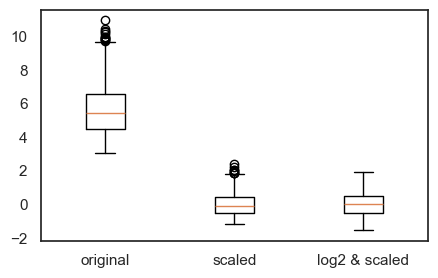

In [47]:
# 1: We want to observe the effect of data transformation in this exercise. Scale the expression matrix with the scale() function. In addition, try taking the logarithm of the data with the log2() function prior to scaling. Make box plots of the unscaled and scaled data sets using the boxplot() function.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(exp_file)

data_log = np.log2(exp_file)
data_log_scaled = scaler.fit_transform(data_log)

fig, ax = plt.subplots(figsize=(5, 3))
plt.boxplot([exp_file.mean(axis=1), data_scaled.mean(axis=1), data_log_scaled.mean(axis=1)]) # mean performed along columns
ax.set_xticks([1, 2, 3], labels=['original', 'scaled', 'log2 & scaled'])
plt.show()

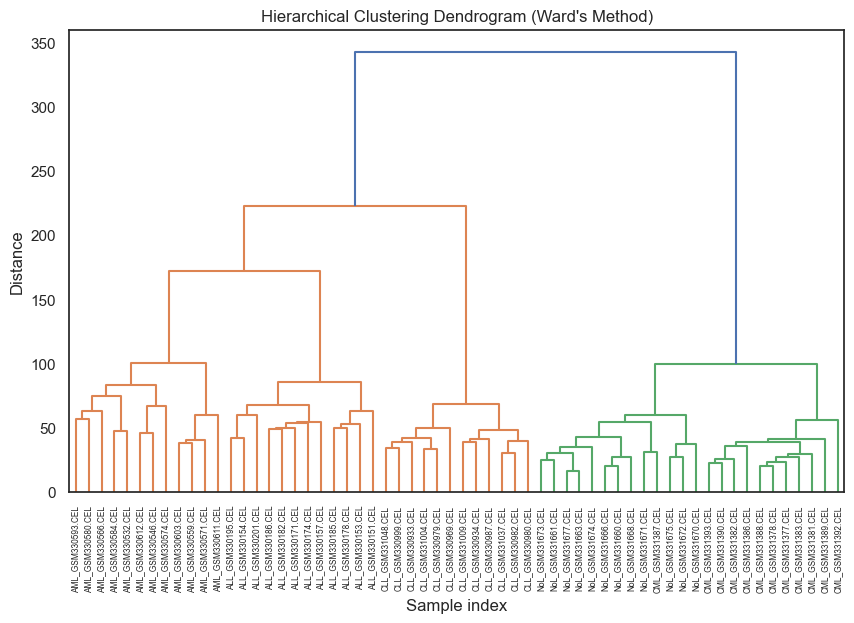

/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


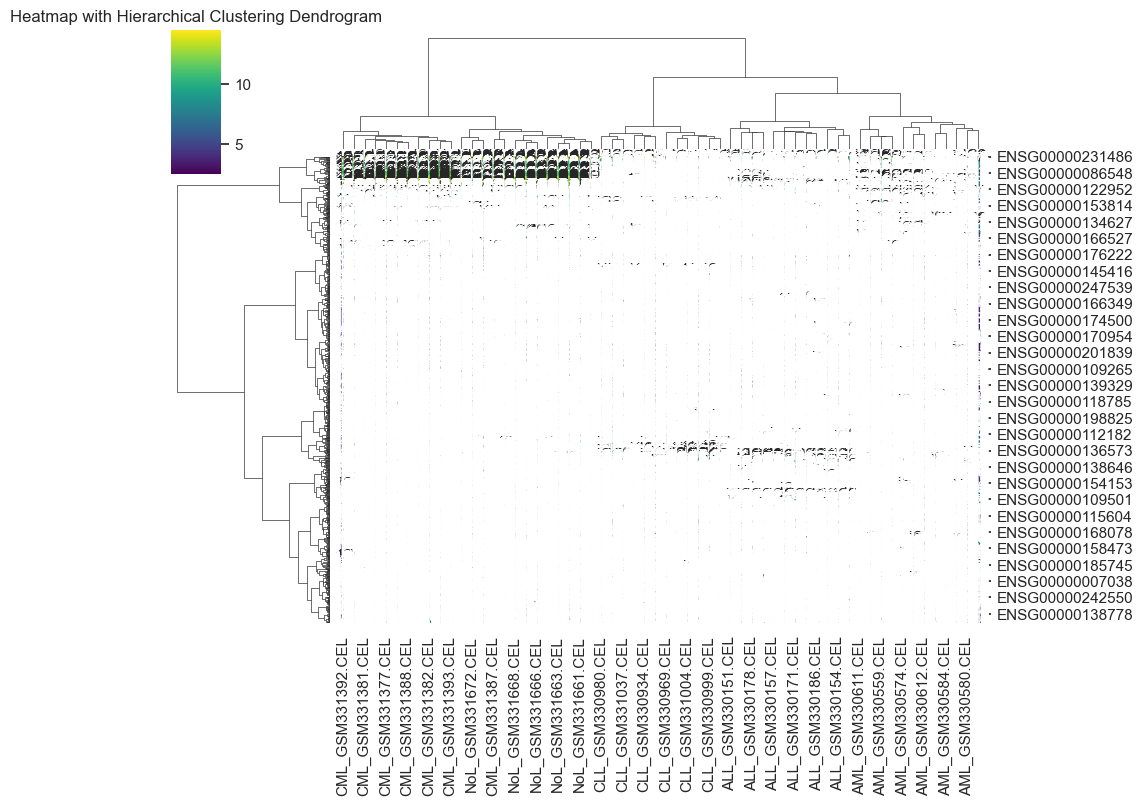

Cluster assignments for k=3: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


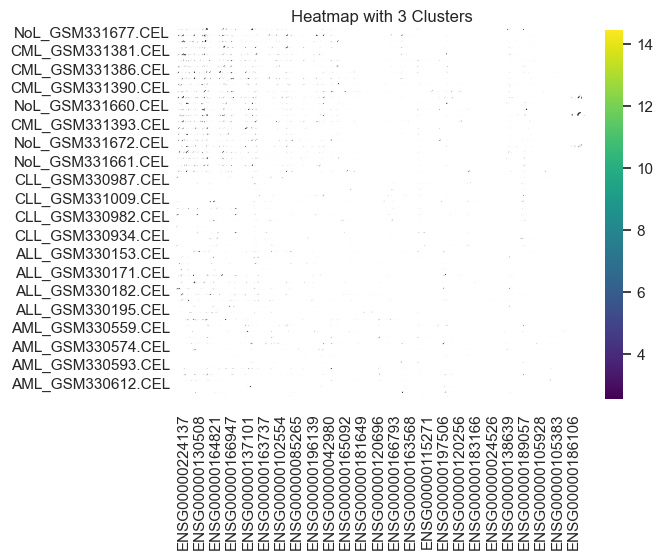

Cluster assignments for k=4: [3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


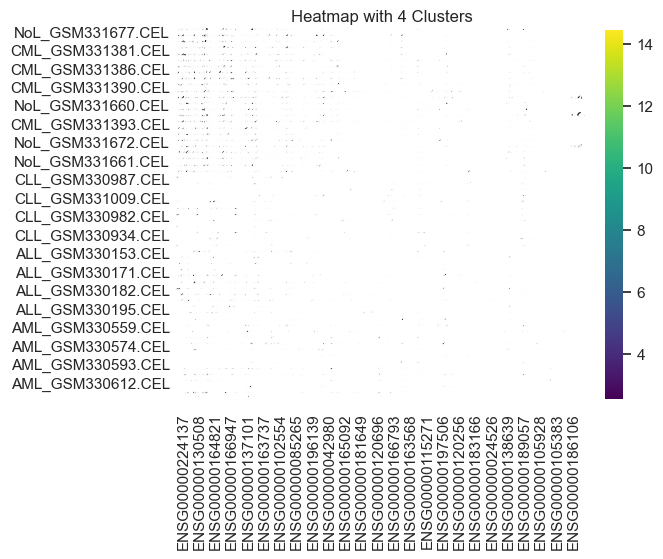

Cluster assignments for k=5: [3 3 3 3 3 3 3 3 3 3 3 3 5 5 4 5 4 5 5 5 5 4 4 5 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


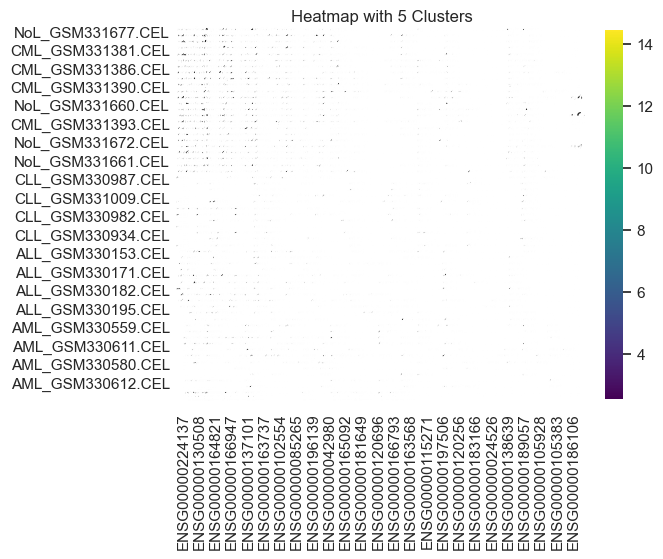

In [45]:
# 2: For the same problem above using the unscaled data and different data transformation strategies, use the ward.d distance in hierarchical clustering and plot multiple heatmaps. You can try to use the pheatmap library or any other library that can plot a heatmap with a dendrogram. Which data-scaling strategy provides more homogeneous clusters with respect to disease types?

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

mat = exp_file

dists = pdist(mat.T, metric='euclidean')

# Perform hierarchical clustering using Ward's method
Z = linkage(dists, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=mat.columns, orientation='top', distance_sort='descending', above_threshold_color='b')
plt.title('Hierarchical Clustering Dendrogram (Ward\'s Method)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Create a heatmap with the clustering results
sns.clustermap(mat, method='ward', metric='euclidean', cmap='viridis', figsize=(10, 8), annot=True)
plt.title('Heatmap with Hierarchical Clustering Dendrogram')
plt.show()

# If you want to create multiple heatmaps (with different cluster numbers)
# You can use the fcluster function to cut the dendrogram at different levels
cluster_numbers = [3, 4, 5]  # Example: Create heatmaps for 3, 4, and 5 clusters

for k in cluster_numbers:
    clusters = fcluster(Z, k, criterion='maxclust')  # Assign clusters based on the cut-off
    print(f"Cluster assignments for k={k}: {clusters}")
    
    # Add the cluster assignments to the data
    mat_copy = mat.T.copy()
    mat_copy['Cluster'] = clusters
    
    # Sort the rows and columns based on clusters and plot a heatmap
    sorted_mat = mat_copy.sort_values('Cluster').drop('Cluster', axis=1)
    sns.heatmap(sorted_mat, cmap='viridis', annot=True)
    plt.title(f'Heatmap with {k} Clusters')
    plt.show()

/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/olyssa/opt/anaconda3/envs/ml_for_genomics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To re

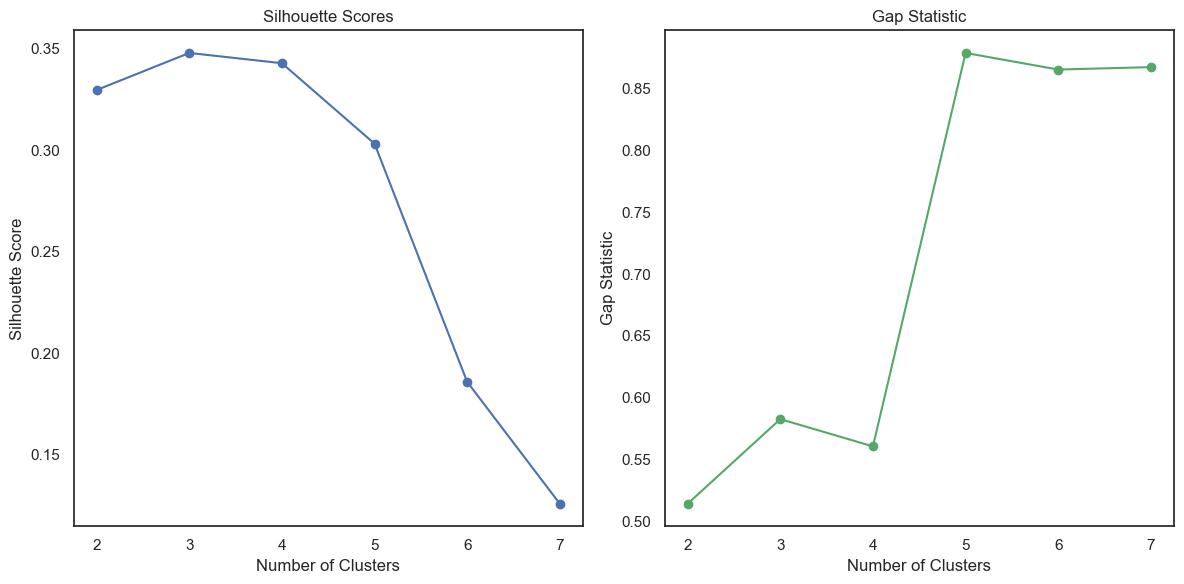

Original Data:
Best k based on Silhouette Score: 3
Best k based on Gap Score: 5

Scaled Data:
Best k based on Silhouette Score: 3
Best k based on Gap Score: 7

Log2 & Scaled Data:
Best k based on Silhouette Score: 3
Best k based on Gap Score: 7


In [48]:
# 3: For the transformed and untransformed data sets used in the exercise above, use the silhouette for deciding number of clusters using hierarchical clustering.
# 4: Now, use the Gap Statistic for deciding the number of clusters in hierarchical clustering. Is it the same number of clusters identified by two methods? Is it similar to the number of clusters obtained using the k-means algorithm in the chapter.

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

k_range = range(2, 8)

def compute_wk(data, labels):
    cluster_centers = np.array([data[labels == i].mean(axis=0) for i in np.unique(labels)])
    dist_matrix = np.array([np.sum((data[labels == i] - cluster_centers[i]) ** 2) for i in range(len(cluster_centers))])
    return np.sum(dist_matrix)

def calc_scores(data):
    silhouette_scores = []
    gap_scores = []
    
    # Calculate the clustering scores for each k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=101, n_init='auto')
        kmeans.fit(data)
        
        # Silhouette Score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
        # Gap statistics
        kmedoids = KMedoids(n_clusters=k, random_state=101, metric='euclidean')
        kmedoids.fit(data)
        Wk = compute_wk(data, kmedoids.labels_)
        Wk_ref = []
        for b in range(50):
            random_data = np.random.uniform(data.min(), data.max(), size=data.shape)  # Random uniform reference data
            kmedoids_ref = KMedoids(n_clusters=k, random_state=101, metric='euclidean')
            kmedoids_ref.fit(random_data)
            Wk_ref.append(compute_wk(random_data, kmedoids_ref.labels_))
            
        # Compute the gap statistic
        gap_value = np.log(np.mean(Wk_ref)) - np.log(Wk)
        gap_scores.append(gap_value)
        
    return silhouette_scores, gap_scores

silhouette_scores, gap_scores = calc_scores(exp_file.T)

# Plot the results of the metrics to find the best k
plt.figure(figsize=(12, 6))

# Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o', color='b', label="Silhouette Score")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

# Gap statistic
plt.subplot(1, 2, 2)
plt.plot(k_range, gap_scores, marker='o', color='g', label="Gap Statistic")
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic')

plt.tight_layout()
plt.show()

best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_gap = k_range[np.argmax(gap_scores)]

print('Original Data:')
print(f"Best k based on Silhouette Score: {best_k_silhouette}")
print(f"Best k based on Gap Score: {best_k_gap}")

silhouette_scores, gap_scores = calc_scores(data_scaled.T)
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_gap = k_range[np.argmax(gap_scores)]
print('\nScaled Data:')
print(f"Best k based on Silhouette Score: {best_k_silhouette}")
print(f"Best k based on Gap Score: {best_k_gap}")

silhouette_scores, gap_scores = calc_scores(data_log_scaled.T)
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_gap = k_range[np.argmax(gap_scores)]
print('\nLog2 & Scaled Data:')
print(f"Best k based on Silhouette Score: {best_k_silhouette}")
print(f"Best k based on Gap Score: {best_k_gap}")

##### 2.3.2 Dimension reduction

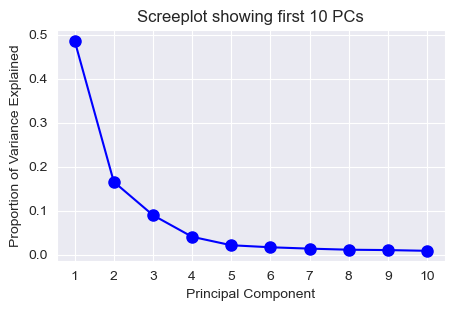


Amount of components to explain 95.24 % of variation: 25


In [11]:
# 1: Do PCA on the expression matrix using the princomp() function and then use the screeplot() function to visualize the explained variation by eigenvectors. How many top components explain 95% of the variation?

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mat = exp_file

# Standardize the matrix
scaler = StandardScaler()
mat_scaled = scaler.fit_transform(mat)

# Perform PCA
pca = PCA()
pca.fit(mat_scaled)

# Explained variance ratio (proportion of variance explained by each PC)
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), explained_variance[:10], marker='o', linestyle='-', color='b', markersize=8)
plt.title("Screeplot showing first 10 PCs")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Summary of PCA
cumulative_variance = np.cumsum(explained_variance[:10])
    
c_variance = 0
counter = 0
while c_variance < 0.95:
    c_variance += explained_variance[counter]
    counter += 1
print(f"\nAmount of components to explain {round(c_variance*100, 2)} % of variation:", counter)

In [18]:
# 2: Our next tasks are to remove eigenvectors and reconstruct the matrix using SVD, then calculate the reconstruction error as the difference between original and reconstructed matrix. HINT: You have to use the svd() function and equalize eigenvalue to 0 for the component you want to remove.

matlogscl = np.log2(exp_file)

# Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(matlogscl, full_matrices=False)

# Create the diagonal matrix of singular values
D = np.diag(S)

# Reconstruct the matrix with all eigenvectors
mat_rec1 = U @ D @ Vt

# Remove the 2nd eigenvector by setting its singular value to 0
D2 = D.copy()
D2[1, 1] = 0
mat_rec2 = U @ D2 @ Vt

# Compute reconstruction error
reconstruction_error_2nd = np.sum((mat_rec1 - mat_rec2) ** 2)
print(f"Reconstruction error after removing 2nd eigenvector: {reconstruction_error_2nd}")

# Remove only the 4th eigenvector
D4 = D.copy()
D4[3, 3] = 0
mat_rec4 = U @ D4 @ Vt

# Compute reconstruction error
reconstruction_error_4th = np.sum((mat_rec1 - mat_rec4) ** 2)
print(f"Reconstruction error after removing 4th eigenvector: {reconstruction_error_4th}")

Reconstruction error after removing 2nd eigenvector: 3095.1374760013873
Reconstruction error after removing 4th eigenvector: 587.1580198969513


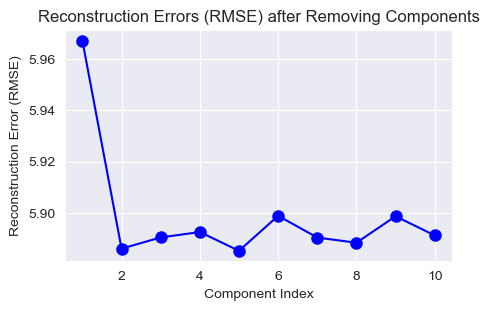

Order of reconstruction errors: [ 5  2  8  7  3 10  4  9  6  1]


In [20]:
# 3: Produce a 10-component ICA from the expression data set. Remove each component and measure the reconstruction error without that component. Rank the components by decreasing reconstruction-error.

from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error

mat = exp_file

# Perform ICA (Independent Component Analysis)
ica = FastICA(n_components=10, random_state=101)
S = ica.fit_transform(mat.T)  # Independent components (source matrix)
A = ica.mixing_  # Mixing matrix
X_reconstructed = np.dot(S, A.T)  # Reconstructed matrix

# Initialize reconstruction errors
rec_err = []

# Iterate over 10 components
for i in range(10):
    # Temporarily zero out the i-th component in S
    S_temp = S.copy()
    S_temp[:, i] = 0

    # Reconstruct matrix with the modified components
    X_modified = np.dot(S_temp, A.T)

    # Calculate RMSE and store it
    rmse = np.sqrt(mean_squared_error(mat.T, X_modified))
    rec_err.append(rmse)

# Plot reconstruction errors
plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), rec_err, marker='o', linestyle='-', color='b', markersize=8)
plt.title("Reconstruction Errors (RMSE) after Removing Components")
plt.xlabel("Component Index")
plt.ylabel("Reconstruction Error (RMSE)")
plt.grid(True)
plt.show()

# Order of reconstruction errors
ordered_indices = np.argsort(rec_err) + 1  # +1 for 1-based indexing like in R
print("Order of reconstruction errors:", ordered_indices)

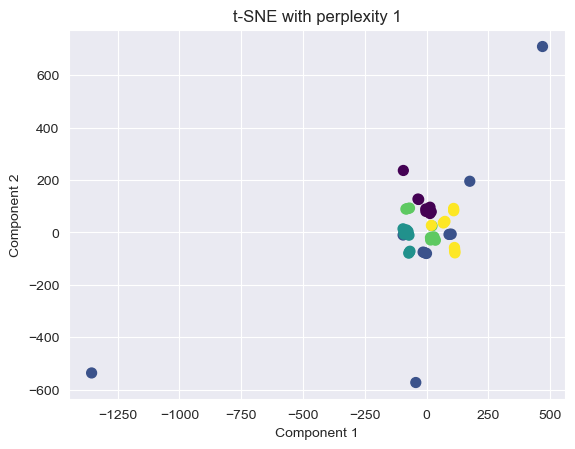

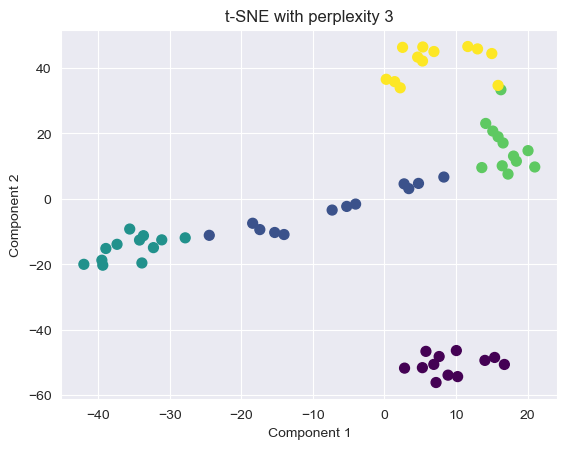

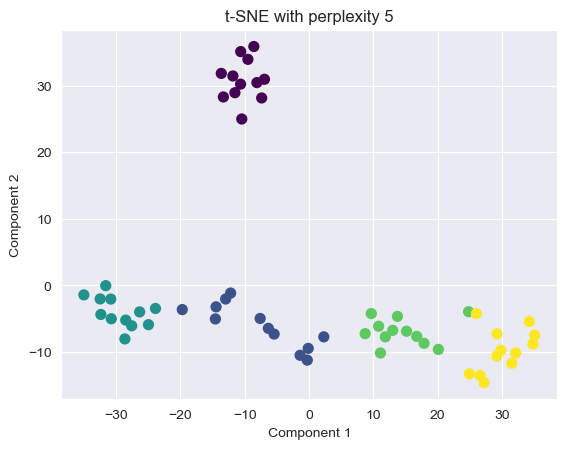

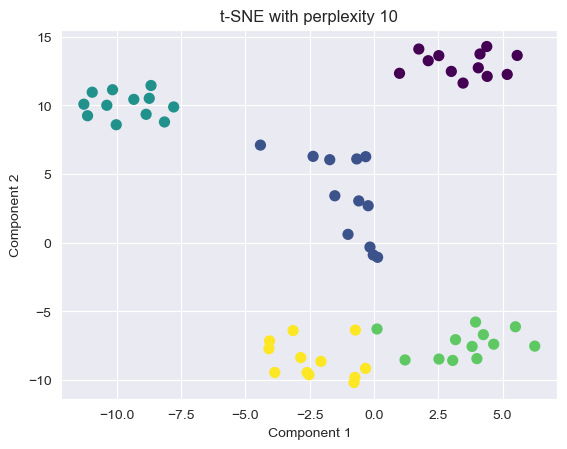

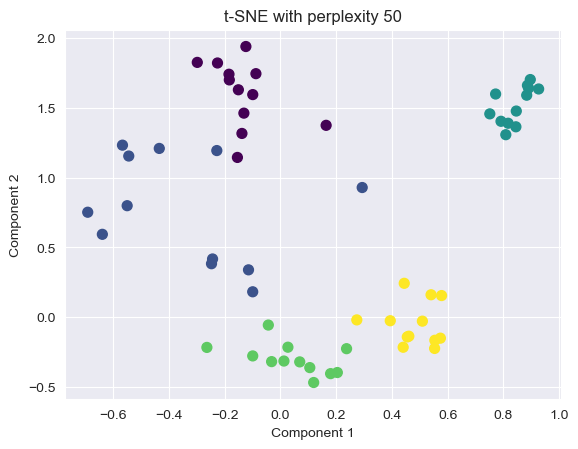

In [22]:
# 4: In this exercise we use the Rtsne() function on the leukemia expression data set. Try to increase and decrease perplexity t-sne, and describe the observed changes in 2D plots.

from sklearn.manifold import TSNE

mat = exp_file

# Create the LeukemiaType annotation
annotation_col = pd.DataFrame({
    'LeukemiaType': [col[:3] for col in mat.columns]
}, index=mat.columns)

# Define a function to run t-SNE and plot results
def run_tsne_and_plot(data, perplexity, labels):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_out = tsne.fit_transform(data.T)  # Transpose to cluster by samples
    plt.scatter(tsne_out[:, 0], tsne_out[:, 1], c=pd.factorize(labels)[0], cmap='viridis', s=50)
    plt.title(f"t-SNE with perplexity {perplexity}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Run t-SNE for different perplexity values and plot
for perplexity in [1, 3, 5, 10, 50]:
    run_tsne_and_plot(mat, perplexity, annotation_col['LeukemiaType'])